In [27]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-16_15-31-02/metrics.csv'
metadata_path = '../data/metadata/metadata.csv'

df = pd.read_csv(my_analysis_path)

In [28]:
df['is_valid'].value_counts(dropna=False)

is_valid
True     1729
False      91
Name: count, dtype: int64

In [29]:
df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()

,subject_id,trial_type,is_valid
0,1,PART_A,10
1,1,PART_B,10
2,2,PART_A,10
3,2,PART_B,9
4,3,PART_A,10
...,...,...,...
177,97,PART_B,10
178,98,PART_A,8
179,98,PART_B,9
180,99,PART_A,10


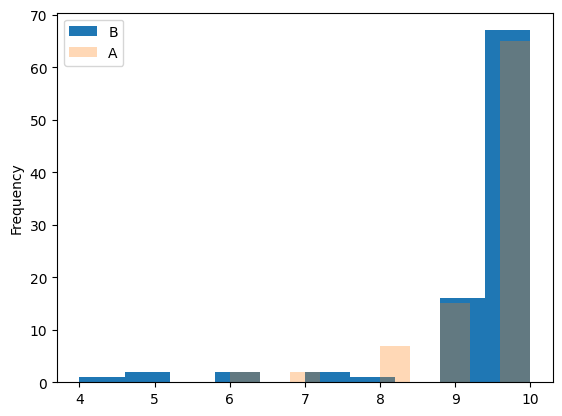

In [30]:
df_grouped = df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()
df_grouped[df_grouped['trial_type'] == 'PART_B']['is_valid'].plot(kind="hist")
df_grouped[df_grouped['trial_type'] == 'PART_A']['is_valid'].plot(kind="hist", alpha=0.3)
plt.legend(['B', 'A'])
df_grouped

# Pivot to have PART_A and PART_B sums in separate columns
df_pivot = df_grouped.pivot(index='subject_id', columns='trial_type', values='is_valid').reset_index()
df_pivot.columns = ['subject_id', 'is_valid_sum_A', 'is_valid_sum_B']

df = df.merge(df_pivot, on='subject_id')
df['is_valid_sum_A'] = (df['is_valid_sum_A'] / 10) * 100
df['is_valid_sum_B'] = (df['is_valid_sum_B'] / 10) * 100


In [31]:
def clean_metadata(path_to_metadata):
    df = (
    (
        pd.read_csv(path_to_metadata)
        .rename(
            columns={
                "Anteojos o lentes de contacto": "glasses",
                "Años de escolaridad": "years_of_education",
                "MMSE / 30": "MMSE",
                "Reloj / 3": "clock_drawing_test",
                "Nro de participante": "suj",
                "Género": "sex",
                "Edad": "age",
                "Grupo": "group",
                "TMT A papel PB": "tmt_a_raw",
                "TMT B papel PB": "tmt_b_raw",
                "Digit Symbol pb": "digit_symbol_raw",
                "Span directo pb": "forward_digit_pan",
                "span inverso pb": "backward_digit_pan",
                "reloj": "clock_drawing_test",
            }
        )
        .replace("Caso ?", "Caso")
    )
    .drop([0, 1])
    .reset_index(drop=True) 
    )  # 0 and 1 are summary


    df.columns = [x.lower() for x in df.columns]
    print(df.columns)
    df = df.replace(",", ".", regex=True)
    df["sex"] = df["sex"].replace({"F": 1, "M": 0}).astype("Int64")
    df["group"] = df["group"].str.lower()
    df = df.replace("caso", "mci")
    z_score_cols = [col for col in df.columns if col[-1] == "z"]
    df = df.drop(z_score_cols, axis=1).reset_index(drop=True)
    df = df.replace("Suspendido", 300).replace("No logra", 300)  # 300 seconds it is the max time based on the literature
    df['digit_symbol_raw'] = df['digit_symbol_raw'].replace('no se lo administraron', np.nan).astype(float)
    df = df.astype({"tmt_a_raw": float, "tmt_b_raw": float})
    df["suj"] = df["suj"].astype(int)
    return df

In [32]:
df_metadata = clean_metadata(metadata_path)
df_metadata



Index(['suj', 'group', 'clasificación de caso',
       'comentario (tipo de caso o criterio de exclusión)', 'id participante',
       'fecha', 'hora', 'neuropsicol.', 'eyetracker', 'sex', 'age', 'glasses',
       'observaciones', 'mmse', 'mmse fallas', 'tmt_a_raw', 'tmt a (papel) z',
       'tmt_b_raw', 'tmt b papel errores', 'tmt b (papel) z',
       'digit_symbol_raw', 'digit - symbol z', 'forward_digit_pan',
       'span directo z', 'backward_digit_pan', 'span inverso z',
       'clock_drawing_test', 'years_of_education'],
      dtype='object')


,suj,group,clasificación de caso,comentario (tipo de caso o criterio de exclusión),id participante,fecha,hora,neuropsicol.,eyetracker,sex,age,glasses,observaciones,mmse,mmse fallas,tmt_a_raw,tmt_b_raw,tmt b papel errores,digit_symbol_raw,forward_digit_pan,backward_digit_pan,clock_drawing_test,years_of_education
0,1,control,NaN,*,946462,22/1/2024,14:30,Betsabé,Gus,1,52,-,No trajo los lentes para ver de cerca,30.0,--,32.00,47.00,NaN,63.0,6.0,4.0,2.0,18.0
1,2,control,NaN,*,2684844,22/1/2024,15:00,Betsabé,Gus,0,78,Anteojos,NaN,28.0,-2 recuerdo,47.00,82.00,NaN,36.0,6.0,5.0,3.0,16.0
2,3,mci,DCL MD no amnesico,NaN,6305,22/1/2024,15:30,Laura,Gus,1,68,Anteojos,NaN,28.0,-2 atención,65.00,107.00,NaN,45.0,5.0,4.0,3.0,12.0
3,4,mci,DCL MD no amnesico,NaN,2060316,22/1/2024,16:00,Laura,Gus,1,80,Anteojos,NaN,28.0,-1 atención. -1 recuerdo,55.00,109.00,NaN,38.0,5.0,4.0,3.0,15.0
4,5,mci,DCL MD no amnesico,NaN,4744,22/1/2024,16:30,Betsabé,Gus,1,87,Anteojos,NaN,25.0,-2 OT. -1 At. -1 rec. -1VC,63.00,180.09,(2 errores),32.0,5.0,3.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,DCL no amnesico,NaN,2302423,7/10/2024,13hs,Betsabe,Alejandro,1,75,anteojos,NaN,27.0,1 atenc. 2 recuerdo,38.90,93.70,2 errores,28.0,7.0,4.0,3.0,12.0
96,98,mci,DCL no amnesico,NaN,3104154,21/10/2024,13hs,Betsabe,Alejandro,1,70,anteojos,NaN,29.0,1 recuerdo,40.36,140.00,4 errores,46.0,5.0,4.0,3.0,15.0
97,99,mci,DCL no amnesico,NaN,2486596,21/10/2024,1:15:00 p.m.,Betsabe,Alejandro,1,71,NaN,NaN,29.0,1 recuerdo,51.80,78.30,NaN,42.0,6.0,6.0,3.0,18.0
98,100,control,NaN,NaN,22945,11/11/2024,13hs,Betsabe,Alejandro,0,76,anteojos,NaN,29.0,1 VC,50.42,69.40,-,40.0,8.0,5.0,3.0,18.0


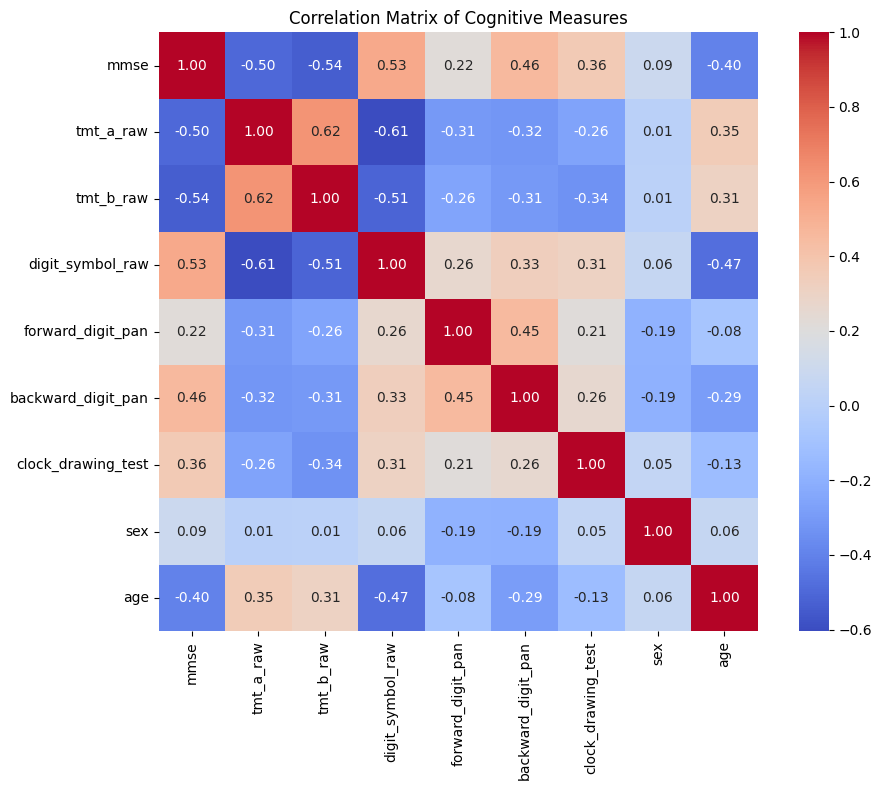

In [33]:
# Clean and convert appropriate columns to numeric
cognitive_columns = ['mmse', 'tmt_a_raw',
                    'tmt_b_raw', 'digit_symbol_raw', 'forward_digit_pan',
                    'backward_digit_pan', 'clock_drawing_test']

demographic_colums = ['sex', 'age']

group_column = ['group']

# Compute correlation matrix
corr_matrix = df_metadata[cognitive_columns + demographic_colums].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cognitive Measures")
plt.tight_layout()
plt.show()

In [34]:

# Clean and convert appropriate columns to numeric
cognitive_columns = ['mmse', 'tmt_a_raw',
                    'tmt_b_raw', 'digit_symbol_raw', 'forward_digit_pan',
                    'backward_digit_pan', 'clock_drawing_test']

demographic_colums = ['sex', 'age', 'years_of_education']

group_column = ['group']

df_metadata_cognitive = df_metadata[['suj','group'] + demographic_colums + cognitive_columns].copy()

df_all = df.merge(df_metadata_cognitive, left_on='subject_id', right_on='suj').rename(columns={"sex_y": "sex", "age_y": "age", "group_y": "group"})
keep_cols = [i for i in df_all.columns if "_x" not in i]
df_all = df_all[keep_cols]

In [35]:
df_metadata_cognitive

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_b_raw,digit_symbol_raw,forward_digit_pan,backward_digit_pan,clock_drawing_test
0,1,control,1,52,18.0,30.0,32.00,47.00,63.0,6.0,4.0,2.0
1,2,control,0,78,16.0,28.0,47.00,82.00,36.0,6.0,5.0,3.0
2,3,mci,1,68,12.0,28.0,65.00,107.00,45.0,5.0,4.0,3.0
3,4,mci,1,80,15.0,28.0,55.00,109.00,38.0,5.0,4.0,3.0
4,5,mci,1,87,10.0,25.0,63.00,180.09,32.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,1,75,12.0,27.0,38.90,93.70,28.0,7.0,4.0,3.0
96,98,mci,1,70,15.0,29.0,40.36,140.00,46.0,5.0,4.0,3.0
97,99,mci,1,71,18.0,29.0,51.80,78.30,42.0,6.0,6.0,3.0
98,100,control,0,76,18.0,29.0,50.42,69.40,40.0,8.0,5.0,3.0


In [36]:
# ['suj', 'group', 'sex']
df_all.columns

Index(['subject_id', 'trial_id', 'trial_type', 'is_valid',
       'trial_order_of_appearance', 'speed_threshold', 'zigzag_amplitude',
       'total_distance', 'rt', 'mean_speed', 'std_speed', 'peak_speed',
       'mean_acceleration', 'std_acceleration', 'peak_acceleration',
       'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions',
       'hesitation_ratio', 'total_hesitations', 'average_duration',
       'max_duration', 'hesitation_periods', 'correct_targets_touches',
       'wrong_targets_touches', 'number_of_crosses',
       'distance_difference_from_ideal', 'area_difference_from_ideal',
       'intra_target_time', 'inter_target_time', 'invalid_cau

In [37]:
df_metadata_cognitive

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_b_raw,digit_symbol_raw,forward_digit_pan,backward_digit_pan,clock_drawing_test
0,1,control,1,52,18.0,30.0,32.00,47.00,63.0,6.0,4.0,2.0
1,2,control,0,78,16.0,28.0,47.00,82.00,36.0,6.0,5.0,3.0
2,3,mci,1,68,12.0,28.0,65.00,107.00,45.0,5.0,4.0,3.0
3,4,mci,1,80,15.0,28.0,55.00,109.00,38.0,5.0,4.0,3.0
4,5,mci,1,87,10.0,25.0,63.00,180.09,32.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,1,75,12.0,27.0,38.90,93.70,28.0,7.0,4.0,3.0
96,98,mci,1,70,15.0,29.0,40.36,140.00,46.0,5.0,4.0,3.0
97,99,mci,1,71,18.0,29.0,51.80,78.30,42.0,6.0,6.0,3.0
98,100,control,0,76,18.0,29.0,50.42,69.40,40.0,8.0,5.0,3.0


In [38]:
df_valid = df[df["is_valid"]]

df_valid.columns

Index(['subject_id', 'trial_id', 'trial_type', 'is_valid',
       'trial_order_of_appearance', 'speed_threshold', 'zigzag_amplitude',
       'total_distance', 'rt', 'mean_speed', 'std_speed', 'peak_speed',
       'mean_acceleration', 'std_acceleration', 'peak_acceleration',
       'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions',
       'hesitation_ratio', 'total_hesitations', 'average_duration',
       'max_duration', 'hesitation_periods', 'correct_targets_touches',
       'wrong_targets_touches', 'number_of_crosses',
       'distance_difference_from_ideal', 'area_difference_from_ideal',
       'intra_target_time', 'inter_target_time', 'invalid_cau

In [39]:
df = df_all.copy()

df_valid = df[df["is_valid"]]

valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

subjects_with_enough_valid_trials = valid_counts[
    (valid_counts.get('PART_A', 0) >= 2) & (valid_counts.get('PART_B', 0) >= 2)
].index

df_valid = df_valid[df_valid['subject_id'].isin(subjects_with_enough_valid_trials)]


digital_tmt_vars = [
    'speed_threshold', 'total_distance', 'rt',
       'correct_targets_touches', 'wrong_targets_touches', 'mean_speed',
       'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
       'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions',
       'hesitation_ratio', 'total_hesitations', 'average_duration',
       'max_duration','zigzag_amplitude', 'distance_difference_from_ideal', 
       'area_difference_from_ideal',
]

other_test_vars = ['mmse', 'tmt_a_raw', 'tmt_b_raw', 'digit_symbol_raw', 'forward_digit_pan', 'backward_digit_pan', 'clock_drawing_test']

df_digital_tmt = df_valid.pivot_table(index='subject_id', columns="trial_type", values=digital_tmt_vars)

df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]
df_digital_tmt

# df_other_tasks = df_valid.groupby("subject_id")[other_test_vars].mean()

# df_all_tasks = df_other_tasks.join(df_digital_tmt)

df_digital_tmt_with_target = df_digital_tmt.reset_index(names='suj').merge(df_metadata_cognitive[['suj', 'age', 'sex', 'years_of_education', 'group']], on='suj').set_index('suj')
df_digital_tmt_with_target['group'] = df_digital_tmt_with_target['group'].str.replace('mci', '1').replace('control', '0').astype(int)

df_digital_tmt_with_target.shape
df_digital_tmt_with_target

,area_difference_from_ideal_PART_A,area_difference_from_ideal_PART_B,average_duration_PART_A,average_duration_PART_B,correct_targets_touches_PART_A,correct_targets_touches_PART_B,distance_difference_from_ideal_PART_A,distance_difference_from_ideal_PART_B,hesitation_avg_speed_PART_A,hesitation_avg_speed_PART_B,hesitation_distance_PART_A,hesitation_distance_PART_B,hesitation_ratio_PART_A,hesitation_ratio_PART_B,hesitation_time_PART_A,hesitation_time_PART_B,max_duration_PART_A,max_duration_PART_B,mean_abs_acceleration_PART_A,mean_abs_acceleration_PART_B,mean_acceleration_PART_A,mean_acceleration_PART_B,mean_negative_acceleration_PART_A,mean_negative_acceleration_PART_B,mean_speed_PART_A,mean_speed_PART_B,peak_abs_acceleration_PART_A,peak_abs_acceleration_PART_B,peak_acceleration_PART_A,peak_acceleration_PART_B,peak_negative_acceleration_PART_A,peak_negative_acceleration_PART_B,peak_speed_PART_A,peak_speed_PART_B,rt_PART_A,rt_PART_B,search_avg_speed_PART_A,search_avg_speed_PART_B,search_distance_PART_A,search_distance_PART_B,search_time_PART_A,search_time_PART_B,speed_threshold_PART_A,speed_threshold_PART_B,state_transitions_PART_A,state_transitions_PART_B,std_abs_acceleration_PART_A,std_abs_acceleration_PART_B,std_acceleration_PART_A,std_acceleration_PART_B,std_negative_acceleration_PART_A,std_negative_acceleration_PART_B,std_speed_PART_A,std_speed_PART_B,total_distance_PART_A,total_distance_PART_B,total_hesitations_PART_A,total_hesitations_PART_B,travel_avg_speed_PART_A,travel_avg_speed_PART_B,travel_distance_PART_A,travel_distance_PART_B,travel_time_PART_A,travel_time_PART_B,wrong_targets_touches_PART_A,wrong_targets_touches_PART_B,zigzag_amplitude_PART_B,age,sex,years_of_education,group
suj,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.003537,0.002760,0.318163,0.335857,12.700000,11.900000,0.023216,0.020682,0.109817,0.226342,0.258069,0.415967,0.180630,0.238413,1.760097,2.067387,0.736802,0.693238,3.395858,2.863155,0.035178,0.003290,-4.840143,-4.614525,0.252292,0.206193,48.041727,51.645650,45.116163,50.926277,-38.078735,-35.430482,2.518067,2.357428,16341.300000,18661.200000,0.141566,0.107436,1.052061,1.021831,7.974474,9.787094,0.250905,0.250905,28.900000,29.800000,6.281179,5.799848,7.148968,6.474898,5.504396,5.339590,0.371210,0.333100,3.603225,3.364048,3.400000,4.700000,0.499021,0.414349,2.293095,1.926250,4.649309,4.679597,2.300000,3.100000,1.262666,52,1,18.0,0
2,0.004744,0.005649,0.804681,1.150780,11.000000,9.333333,0.081875,0.088233,0.275423,0.196417,0.751152,0.517830,0.353542,0.455086,3.932325,3.715158,1.930037,2.763528,5.177673,2.857992,-0.010526,-0.014166,-7.021907,-5.347069,0.218349,0.126149,84.805375,76.110207,80.034374,66.145954,-76.835847,-64.407217,3.540814,3.120171,21871.700000,25017.666667,0.117752,0.058690,1.169007,0.863713,10.097550,15.076374,0.202085,0.202085,27.700000,22.000000,9.173771,6.561089,10.560526,7.169251,10.222035,8.337186,0.382189,0.288204,4.037691,2.838481,4.700000,3.555556,0.431585,0.417095,2.117532,1.456938,4.750163,3.643709,6.800000,3.111111,2.601229,78,0,16.0,0
3,0.004309,0.004641,0.385317,0.832404,12.100000,11.500000,0.053798,0.068700,0.221629,0.120955,0.404075,0.341054,0.233823,0.365433,1.880910,3.153832,0.872165,1.746753,2.887850,2.025144,0.025524,-0.027891,-4.095468,-3.576737,0.211050,0.155287,47.848607,38.862292,47.440821,35.077518,-37.516094,-36.039206,2.443123,1.965225,22939.600000,25017.100000,0.105245,0.075936,1.073316,1.036071,10.590629,13.738224,0.157889,0.157889,30.400000,27.300000,5.149999,4.067202,5.913155,4.548789,5.140858,4.651588,0.320057,0.264442,3.790343,3.412193,4.700000,4.200000,0.402126,0.399456,2.312952,2.035068,5.788363,5.073949,3.100000,4.100000,2.023339,68,1,12.0,1
4,0.010872,0.008507,0.773556,1.859370,2.888889,3.250000,0.146933,0.173550,0.252331,0.166556,2.473458,2.668425,0.673204,0.850067,9.919365,16.290851,2.503792,5.347980,3.346226,2.527158,0.027682,-0.008153,-3.927048,-3.569324,0.277021,0.182410,41.532974,50.604258,37.689157,47.371710,-34.

{0: 40, 1: 51}


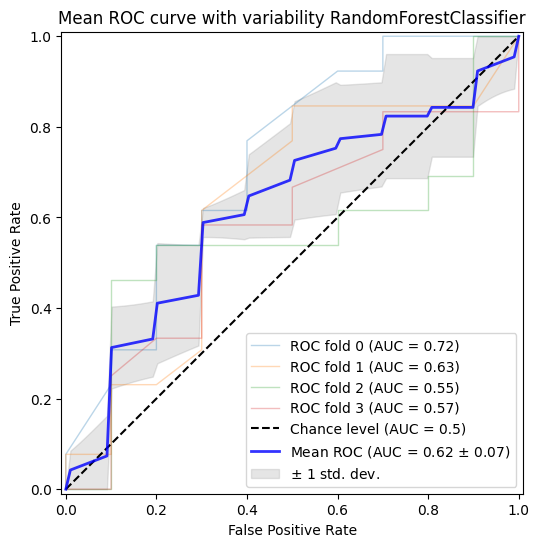

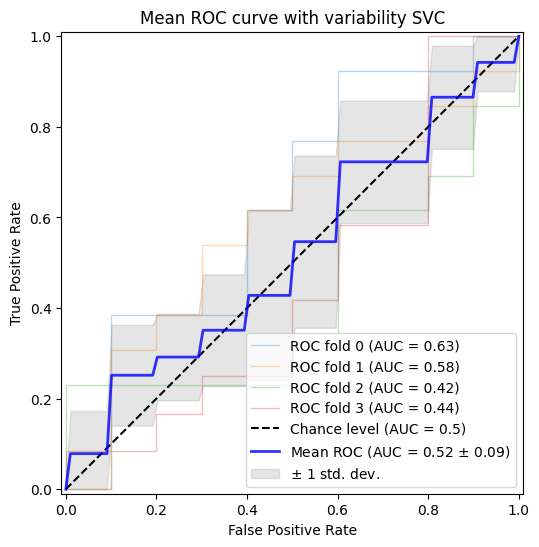

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

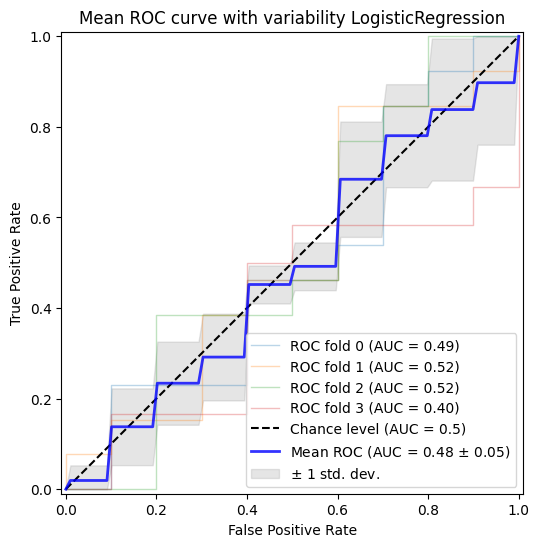

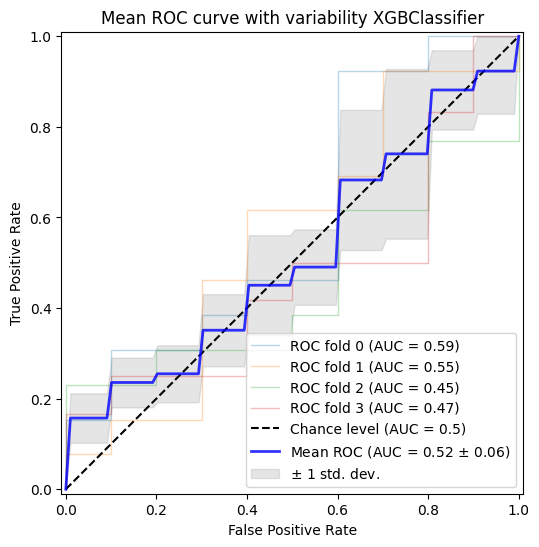

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier

# Features & Target
X = df_digital_tmt_with_target.iloc[:, :-1].values
y = df_digital_tmt_with_target.iloc[:, -1].values

unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


for model in [RandomForestClassifier(n_estimators=100, random_state=41),
              SVC(kernel='linear', C=1, random_state=42),
              LogisticRegression(max_iter=1000, random_state=42),
              xgb.XGBClassifier(tree_method="hist"),]:
            #   HistGradientBoostingClassifier(random_state=42),
            #   CatBoostClassifier(verbose=0, random_state=42)]:
    
    model_name = model.__class__.__name__
    

    # Pipeline always includes scaler (safe for SVM, LR; harmless for RF)
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        # ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Stratified CV
    n_splits = 4
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        pipeline.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            pipeline,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)


    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability {model_name}",
    )
    ax.legend(loc="lower right")
    plt.show()

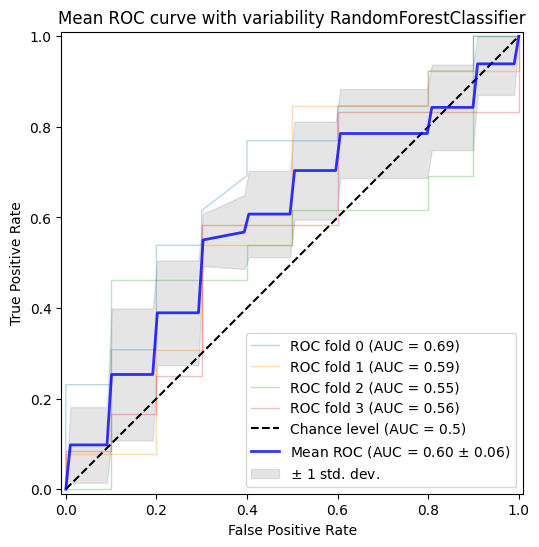

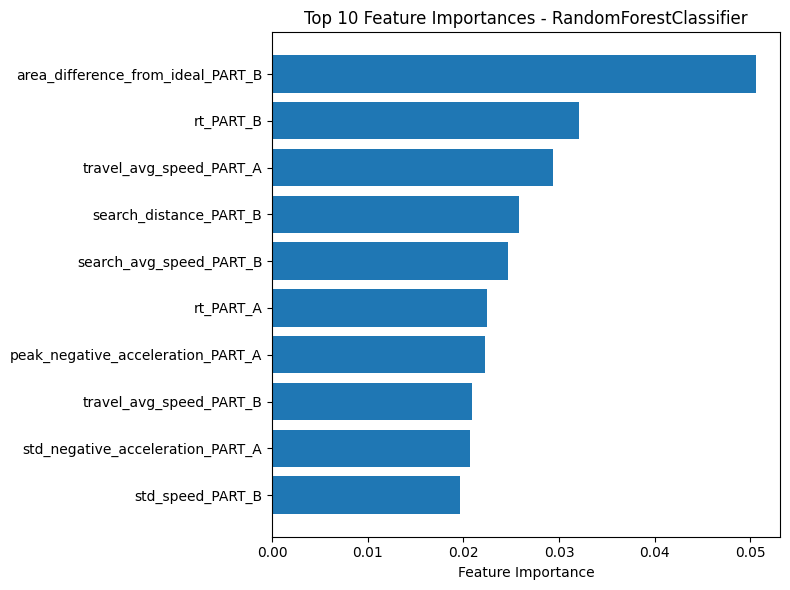

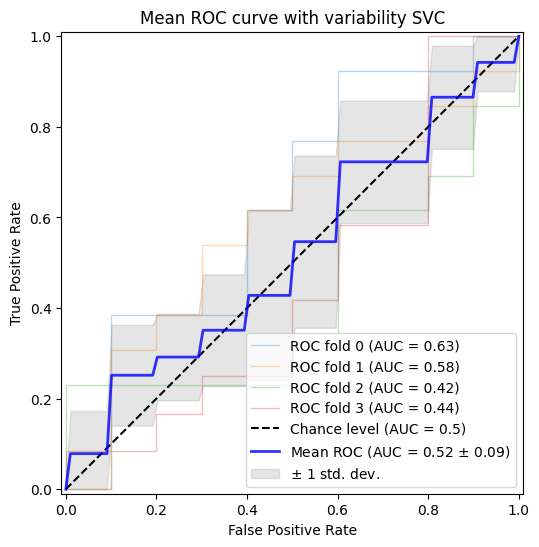

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

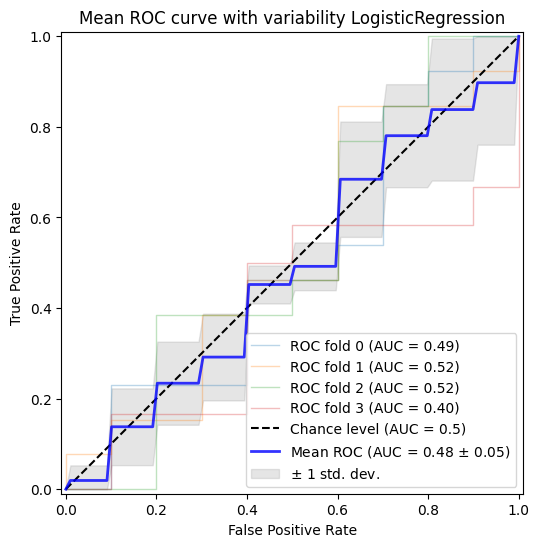

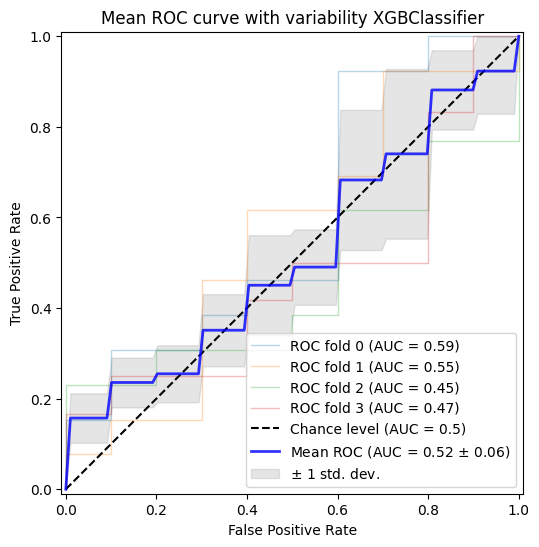

In [54]:
importances_added = False  # Prevents printing for every fold

for model in [RandomForestClassifier(n_estimators=1000, random_state=41),
              SVC(kernel='linear', C=1, random_state=42),
              LogisticRegression(max_iter=1000, random_state=42),
              xgb.XGBClassifier(tree_method="hist")]:
    
    model_name = model.__class__.__name__

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        # ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    n_splits = 4
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        pipeline.fit(X[train], y[train])

        viz = RocCurveDisplay.from_estimator(
            pipeline,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability {model_name}",
    )
    ax.legend(loc="lower right")
    plt.show()

    # Show feature importances for RandomForest
    if model_name == "RandomForestClassifier" and not importances_added:
        clf = pipeline.named_steps['classifier']
        feature_names = df_digital_tmt_with_target.columns[:-1]
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1][:10]  # Top 10 features

        top_features = feature_names[indices]
        top_importances = importances[indices]

        # Plot
        fig2, ax2 = plt.subplots(figsize=(8, 6))
        ax2.barh(range(len(indices)), top_importances[::-1], align='center')
        ax2.set_yticks(range(len(indices)), top_features[::-1])
        ax2.set_xlabel("Feature Importance")
        ax2.set_title(f"Top 10 Feature Importances - {model_name}")
        plt.tight_layout()
        plt.show()

        importances_added = True


In [ ]:
a = pipeline.named_steps['classifier']
a

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


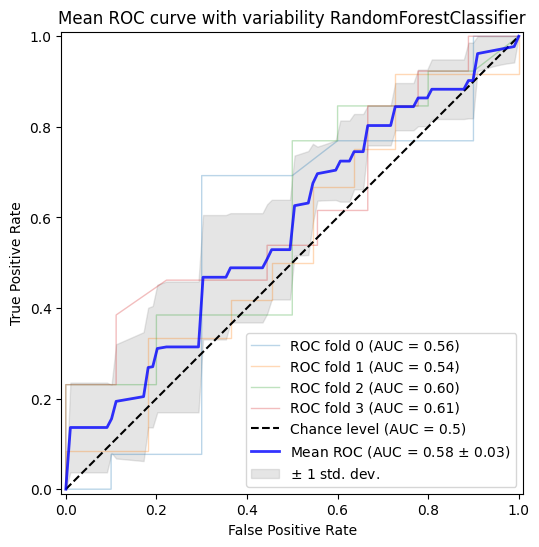


Top 10 Feature Importances for RandomForestClassifier:
1. search_distance_PART_B: 0.0361
2. search_avg_speed_PART_A: 0.0319
3. total_distance_PART_B: 0.0237
4. area_difference_from_ideal_PART_B: 0.0231
5. travel_distance_PART_A: 0.0229
6. correct_targets_touches_PART_B: 0.0223
7. peak_negative_acceleration_PART_B: 0.0208
8. hesitation_ratio_PART_B: 0.0205
9. travel_avg_speed_PART_A: 0.0199
10. mean_speed_PART_A: 0.0196


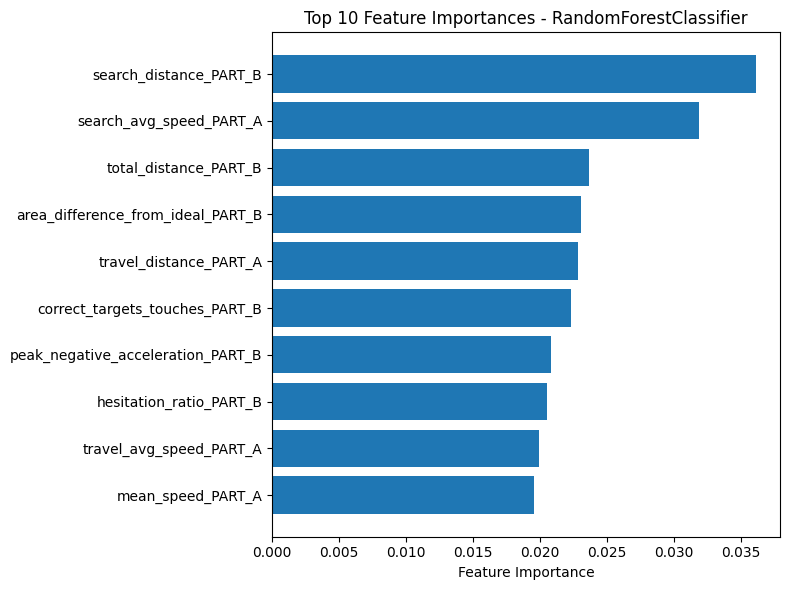

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Discretización y combinación para estratificación
stratify_df = df_digital_tmt_with_target[["age", "group", "sex", "years_of_education"]].copy()

stratify_df["age_bin"] = pd.qcut(stratify_df["age"], q=2, duplicates="drop")
# stratify_df["edu_bin"] = pd.qcut(stratify_df["years_of_education"], q=2, duplicates="drop")

stratify_labels = (
    stratify_df["group"].astype(str) + "_" +
    stratify_df["sex"].astype(str) + "_" +
    stratify_df["age_bin"].astype(str)
)

# Features & Target
X = df_digital_tmt_with_target.iloc[:, :-1].values
y = df_digital_tmt_with_target.iloc[:, -1].values

importances_added = False

for model in [RandomForestClassifier(n_estimators=1000, random_state=41)]:
    model_name = model.__class__.__name__

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        # ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    n_splits = 4
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, stratify_labels)):
        stratify_counts = stratify_labels.value_counts()

        pipeline.fit(X[train], y[train])


        viz = RocCurveDisplay.from_estimator(
            pipeline,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability {model_name}",
    )
    ax.legend(loc="lower right")
    plt.show()
    
    if model_name == "RandomForestClassifier" and not importances_added:
        clf = pipeline.named_steps['classifier']
        feature_names = df_digital_tmt_with_target.columns[:-1]
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1][:10]

        top_features = feature_names[indices]
        top_importances = importances[indices]

        print(f"\nTop 10 Feature Importances for {model_name}:")
        for i, (name, importance) in enumerate(zip(top_features, top_importances)):
            print(f"{i+1}. {name}: {importance:.4f}")

        plt.figure(figsize=(8, 6))
        plt.barh(range(len(indices)), top_importances[::-1], align='center')
        plt.yticks(range(len(indices)), top_features[::-1])
        plt.xlabel("Feature Importance")
        plt.title(f"Top 10 Feature Importances - {model_name}")
        plt.tight_layout()
        plt.show()

        importances_added = True
